# Can We Predict Whether Someone Survived The Titanic Sinking?

The sinking of the Titanic is one the most well known events in human history. Boasting both pop-culture significance and historical relevance there are likely thousands if not millions of people who have asked the question; "Would I survive the Titanic?" While we have no way to go back in time and see for ourselves we thankfully have the second best thing: data. More specifically data on the passengers. We know who they were, where they stayed and most importantly if they survived. Let's take a look at this historical demographic battle royale and see what kind of person was most likely to survive the Titanic.

In [1185]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier



Before we start to do any actual analysis it is a good idea to get a grasp on the data we have.

In [1186]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
train_data.head()
print(train_data.to_string())

     PassengerId  Survived  Pclass                                                                                Name     Sex    Age  SibSp  Parch              Ticket      Fare            Cabin Embarked
0              1         0       3                                                             Braund, Mr. Owen Harris    male  22.00      1      0           A/5 21171    7.2500              NaN        S
1              2         1       1                                 Cumings, Mrs. John Bradley (Florence Briggs Thayer)  female  38.00      1      0            PC 17599   71.2833              C85        C
2              3         1       3                                                              Heikkinen, Miss. Laina  female  26.00      0      0    STON/O2. 3101282    7.9250              NaN        S
3              4         1       1                                        Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.00      1      0              113803   53.1000       

There are 12 categories provided to us. It is a good idea to write down exactly what they each represent.

PassengerId - ID of the Passenger

Pclass - The ticket class the passenger has. The quality goes best to worst 1, 2, 3

Name - The name of the Passenger

Sex - The sex of the passenger Male or Female

Age - The age of the Passenger

SibSp - The number of Siblings or Spouses the Passenger had on board

Parch = The number of Parents or Children the Passenger had on board

Ticket -  The Ticket Number of the Passenger

Fare - The Price paif for the ticket

Cabin - The Cabin they resided in

Embarked - The Port from which they embarked C = Cherbourg, Q = Queenstown, S = Southampton

The Standout Category is Survived

Survived - Whether or not they survived. 1 for Yes, 0 for No.

Our entire model will be built around predicting whether a Passenger gets a 1 or a zero.

Now that we understand the data lets try to clean it up. Lets get rid of any non-essential categories. In a vacuum, 'Name' is actually quite useful as the titles Mr, Miss, and Mrs would allow us to determine whether the passenger was Male or Female and if they were a Female if they had children. However we already have categories for all of those factors which means 'Name' serves no purpose.

In [1187]:
train_data = train_data.drop('Name', axis=1)

test_data = test_data.drop('Name', axis=1)

Now that obvious irrelevncies have be cleared its time to look closer at the values that in the data frame to see if we can actually use them. A category may be relevant but have so many Null variables that it doesn't have any practical use from a model creating standpoint. 

In [1188]:
print(train_data.info())
train_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 76.7+ KB
None


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From the look of things the category with the most Null elements is cabin. Now the cabin by itself is a highly relevant part of a person's chances of survival. Each cabin Value is separated into a letter and a number. While the number is not particularly significant, the letter is very important as it tells us the floor the person was living on. A person living on A near the upper decks and lifeboats has a much higher chance to survive than someone on G who has to traverse 6 floors to make it to the boat. However due to the fact that over 3/4ths of the data is missing, the potential for this category to inaccurately skew the data is too high so it has to be removed.

The other category with a lot of nulls is Age. However, considering that 80% of the data is intact and usable the ratio of survivors to dead should be accurately reflected in this category and thus it stays.

In [1189]:
train_data = train_data.drop('Cabin', axis=1)
test_data = test_data.drop('Cabin', axis=1)

Now that the data is clean we can see the correlations between each remaining category and whether the person survived. We will first do Qualitative Data then move on to Quantitaive data.

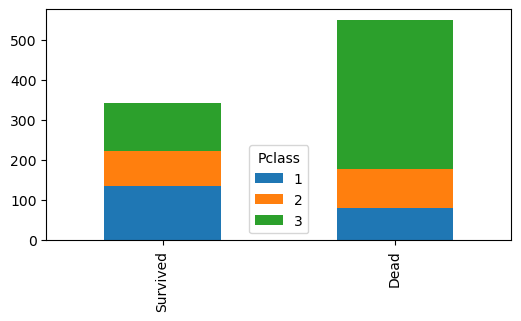

In [1190]:
survived = train_data[train_data['Survived']==1]['Pclass'].value_counts()
survived = survived.sort_index()
dead = train_data[train_data['Survived']==0]['Pclass'].value_counts()
dead = dead.sort_index()
df = pd.DataFrame([survived,dead])
df.index = ['Survived','Dead']
bar = df.plot(kind='bar',stacked=True, figsize=(6,3))

Class has an obvious effect on survival rate as passengers of a higher class have a larger proportion of surviving passengers.


<Axes: >

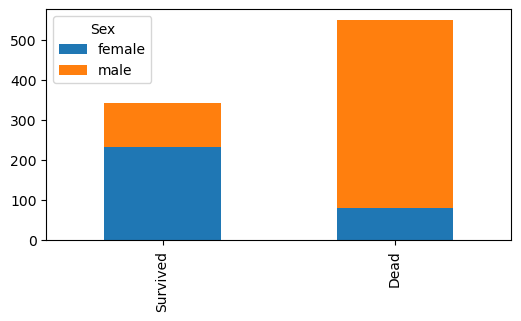

In [1191]:
survived = train_data[train_data['Survived']==1]['Sex'].value_counts()
dead = train_data[train_data['Survived']==0]['Sex'].value_counts()
df = pd.DataFrame([survived,dead])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(6,3))

Sex has a very clear impact on survival rate as the proportion of 'female' passengers who survived is much higher than 'male' passengers. To make it easier for the model to work with lets change male and female to 0's and 1's.

In [1192]:
train_data['Sex'][train_data['Sex'] == 'male'] = 0
train_data['Sex'][train_data['Sex'] == 'female'] = 1

test_data['Sex'][test_data['Sex'] == 'male'] = 0
test_data['Sex'][test_data['Sex'] == 'female'] = 1

train_data.head()

/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_58694/953493097.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_data['Sex'][train_data['Sex'] == 'male'] = 0
/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_5869

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,0,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,1,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,1,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,1,35.0,1,0,113803,53.1000,S
4,5,0,3,0,35.0,0,0,373450,8.0500,S


<Axes: >

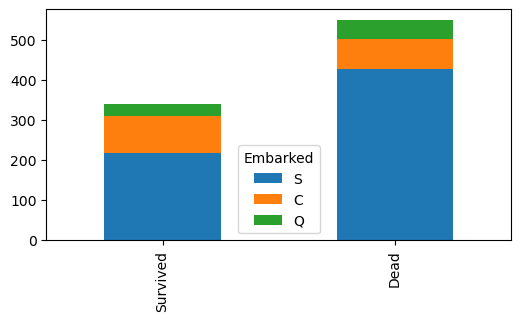

In [1193]:
survived = train_data[train_data['Survived']==1]['Embarked'].value_counts()
dead = train_data[train_data['Survived']==0]['Embarked'].value_counts()
df = pd.DataFrame([survived,dead])
df.index = ['Survived','Dead']
df.plot(kind='bar',stacked=True, figsize=(6,3))

Embark location does not seem to have much effect on survival. The only clear pattern is that those that embarked from Cherbourg have a higher chance of surviving. The only clear difference of embarkments is that Cherbourg had the highest proportion of First Class embarkers at 51%. Because of this correlation it seems the Emabrk is actually just another expression of Class and should not be included in the model.

In [1194]:
#train_data[train_data['Embarked']=='C']['Pclass'].value_counts()

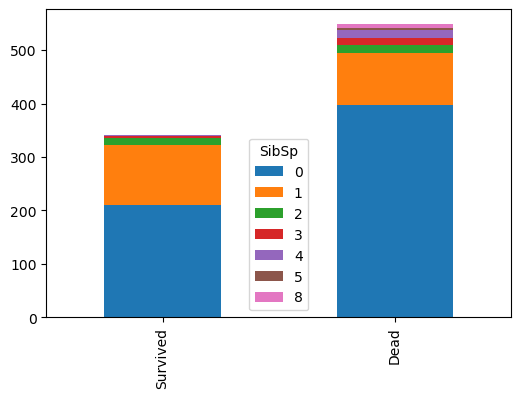

In [1195]:
survived = train_data[train_data['Survived']==1]['SibSp'].value_counts()
survived = survived.sort_index()
dead = train_data[train_data['Survived']==0]['SibSp'].value_counts()
dead = dead.sort_index()
df = pd.DataFrame([survived,dead])
df.index = ['Survived','Dead']
bar = df.plot(kind='bar',stacked=True, figsize=(6,4))


For SibSp the most noticeable impact is that if you have more than 2 Sib/SP you are more likely to die. Aditionally if you have 0 Sib/Sp then you are also more likely to die. The sweetspot seems to be 1 or 2 Sib/SP.

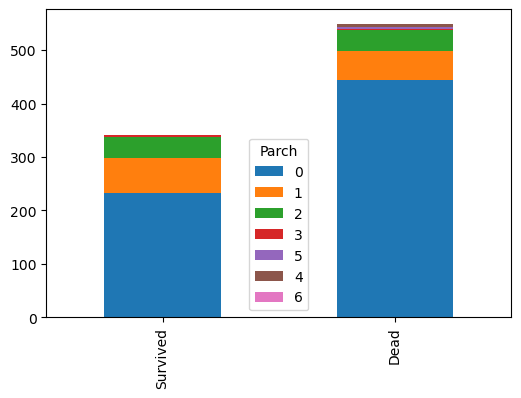

In [1196]:
survived = train_data[train_data['Survived']==1]['Parch'].value_counts()
survived = survived.sort_index()
dead = train_data[train_data['Survived']==0]['Parch'].value_counts()
dead = dead.sort_index()
df = pd.DataFrame([survived,dead])
df.index = ['Survived','Dead']
bar = df.plot(kind='bar',stacked=True, figsize=(6,4))

For Parch the most noticebale impact is that if you have more than 3 Par/Ch on board you are basically garunteed to die. If you have 0 Par/Ch then you are more likely to die and for 1,2 or 3 Par/Ch you have a bout a 50/50 or better shot at surviving.

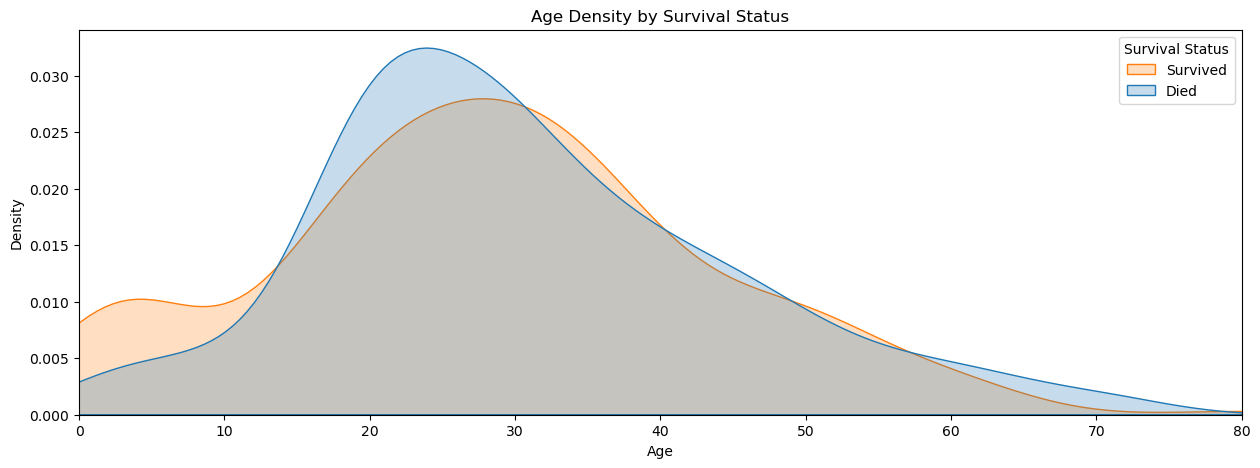

In [1197]:
df = pd.DataFrame({'Age':train_data['Age'],'Survival':train_data['Survived']})

plt.figure(figsize=(15, 5))
sns.kdeplot(data=df, x='Age', hue='Survival', common_norm=False, fill=True)
plt.title('Age Density by Survival Status')
plt.xlim(left=0)
plt.xlim(right=80)
plt.xlabel('Age')
plt.legend(title="Survival Status", labels=['Survived', 'Died'], loc='upper right')
plt.ylabel('Density')
plt.show()

There are 3 main agegroups where Age affects survival. The biggest one is for passengers below the age of around 12 where you have a higher chance of survival. Then between 12 and 32 you have a higher chance of death. Finally for those ages 60+ you are more likely to die. To make the model more accurate at deciding the chance of death we will change the age variable into 6 age sections. 0 to 12, 12 to 32, 32 to 40, 40 to 49, 49 to 57, and 57+.

In [1198]:
train_data['Age'][train_data['Age'] <= 12] = 0
train_data['Age'][(train_data['Age'] > 12) & (train_data['Age'] <= 32) ] = 1
train_data['Age'][(train_data['Age'] > 32) & (train_data['Age'] <= 40) ] = 2
train_data['Age'][(train_data['Age'] > 40) & (train_data['Age'] <= 49) ] = 3
train_data['Age'][(train_data['Age'] > 39) & (train_data['Age'] <= 57) ] = 4
train_data['Age'][train_data['Age'] > 57] = 5

test_data['Age'][test_data['Age'] <= 12] = 0
test_data['Age'][(test_data['Age'] > 12) & (test_data['Age'] <= 32) ] = 1
test_data['Age'][(test_data['Age'] > 32) & (test_data['Age'] <= 40) ] = 2
test_data['Age'][(test_data['Age'] > 40) & (test_data['Age'] <= 49) ] = 3
test_data['Age'][(test_data['Age'] > 39) & (test_data['Age'] <= 57) ] = 4
test_data['Age'][test_data['Age'] > 57] = 5

train_data.head()

/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_58694/3806222281.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_data['Age'][train_data['Age'] <= 12] = 0
/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_58694/3

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,0,1.0,1,0,A/5 21171,7.2500,S
1,2,1,1,1,2.0,1,0,PC 17599,71.2833,C
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,1,2.0,1,0,113803,53.1000,S
4,5,0,3,0,2.0,0,0,373450,8.0500,S


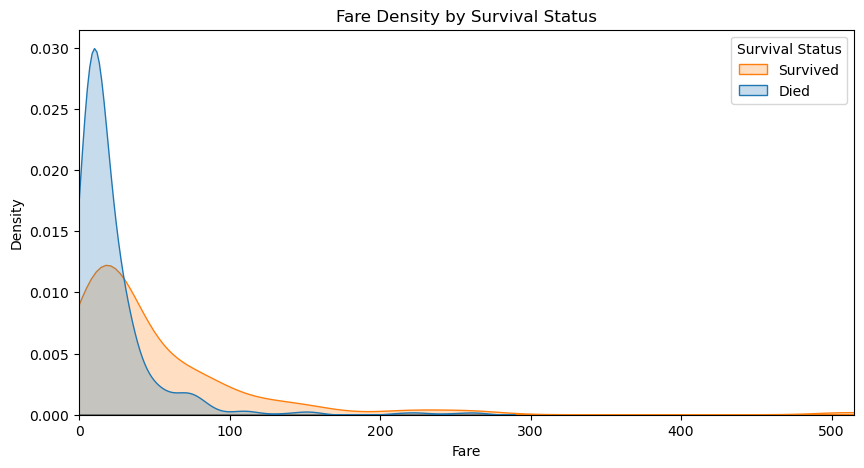

In [1199]:
df = pd.DataFrame({'Fare':train_data['Fare'],'Survival':train_data['Survived']})

plt.figure(figsize=(10, 5))
sns.kdeplot(data=df, x='Fare', hue='Survival', common_norm=False, fill=True)
plt.xlim(left=0)
plt.xlim(right=515)
plt.title('Fare Density by Survival Status')
plt.xlabel('Fare')
plt.legend(title="Survival Status", labels=['Survived', 'Died'], loc='upper right')
plt.ylabel('Density')
plt.show()

Fare price has a very strong impact on survival rate as anyone paying more than around 50 has a higher chance of surving than dying. And anypne paying below 50 has a massivly higher chance of dying. Additionally anyone paying over 290 has a 100% chnace of survival. Lets split up Fare into sections as well. 0 to 30, 30 to 200, 30 to 290 and, 290+.

In [1200]:
train_data['Fare'][train_data['Fare'] <= 30] = 0
train_data['Fare'][(train_data['Fare'] > 30) & (train_data['Fare'] <= 200) ] = 1
train_data['Age'][(train_data['Age'] > 200) & (train_data['Age'] <= 290) ] = 2
train_data['Age'][(train_data['Age'] > 290)] = 3

test_data['Fare'][test_data['Fare'] <= 30] = 0
test_data['Fare'][(test_data['Fare'] > 30) & (test_data['Fare'] <= 200) ] = 1
test_data['Fare'][(test_data['Fare'] > 200) & (test_data['Fare'] <= 290) ] = 2
test_data['Fare'][(test_data['Fare'] > 290)] = 3

train_data.head()

/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_58694/1849330351.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train_data['Fare'][train_data['Fare'] <= 30] = 0
/var/folders/3z/z49y49610b1_cf87nxj0stxh0000gn/T/ipykernel_58694

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,0,1.0,1,0,A/5 21171,0.0,S
1,2,1,1,1,2.0,1,0,PC 17599,1.0,C
2,3,1,3,1,1.0,0,0,STON/O2. 3101282,0.0,S
3,4,1,1,1,2.0,1,0,113803,1.0,S
4,5,0,3,0,2.0,0,0,373450,0.0,S


Looking at all of the data we can tell that in one way or another they all have an impact on the chance of survival and as such they will all be features in the model. 

As shown by the graphs, most of the impacts the data has is not linear. As such we will use a machine learning model known as RandomForest. 

In [1201]:
y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch", "Fare","Age"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=600, max_depth=10, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('Predictions.csv', index=False)


